In [77]:
# import table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import itertools as it
import json
%matplotlib notebook

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.discovery.inductive.variants.im_f import algorithm as im_f_algo
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

from dpv.util.converter import param_transform, downscale, merge
from dpv.variant_transformer import private_transform, public_transform
from dpv.variant_query import variant_query
from dpv.optimizer import release_optimizer
from dpv.data_utility import emd_utility, log_diff

In [13]:
# import xes event log (sepsis example)
log = importer.apply('sepsis.xes')

# process model from xes log
net1, im1, fm1 = im_f_algo.apply(log, parameters=None)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [4]:
# compute summary statistics for single release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # convert to p and k
        p, k = param_transform(eps, d)
        
        for i in range(10):

            # privatize variants            
            traces_orig, traces_priv = private_transform(log, p, k)

            # save results
            fp = open(f"variants_single_{eps}_{d}_{i}.json", "w")
            json.dump(traces_priv, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001
[+] eps: 0.001 delta: 0.5
[+] eps: 0.001 delta: 0.1
[+] eps: 0.001 delta: 0.05
[+] eps: 0.001 delta: 0.01
[+] eps: 0.001 delta: 0.001


In [4]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_single = np.zeros((len(eps_list), len(del_list)))
cost_single = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'single/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_single[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_single[m][n] = np.mean([x for x in tmp_cost if x != 10500])
        print(f'eps: {eps}, delta: {d}, util: {util_single[m][n]}, cost: {cost_single[m][n]}')
        
# save metrics
np.savetxt('single/util_single.txt', util_single)
np.savetxt('single/cost_single.txt', cost_single)

eps: 2, delta: 0.5, util: 0.7705045124850839, cost: 120147.2
eps: 2, delta: 0.1, util: 0.6283703810410824, cost: 153775.6
eps: 2, delta: 0.05, util: 0.6220087144029827, cost: 155873.8
eps: 2, delta: 0.01, util: 0.551471865005982, cost: 165242.3
eps: 2, delta: 0.001, util: 0.5159100836505821, cost: 170808.9
eps: 1, delta: 0.5, util: 0.8402011637687815, cost: 90294.2
eps: 1, delta: 0.1, util: 0.7297895919523825, cost: 129282.7
eps: 1, delta: 0.05, util: 0.6394178838572819, cost: 151418.0
eps: 1, delta: 0.01, util: 0.5662942707555823, cost: 165110.5
eps: 1, delta: 0.001, util: 0.4746081818509823, cost: 142221.8
eps: 0.1, delta: 0.5, util: 0.8890065528277834, cost: 57763.1
eps: 0.1, delta: 0.1, util: 0.7809527261515823, cost: 91099.7
eps: 0.1, delta: 0.05, util: 0.7263642021818819, cost: 110842.6
eps: 0.1, delta: 0.01, util: 0.6225523276670872, cost: 154812.0
eps: 0.1, delta: 0.001, util: 0.44108455715099826, cost: 182256.0
eps: 0.01, delta: 0.5, util: 0.8930111468383798, cost: 54484.4
eps

In [15]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_single = np.zeros((len(eps_list), len(del_list)))
fit_single = np.zeros((len(eps_list), len(del_list)))
gen_single = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_single_avg = []
        fit_single_avg = []
        gen_single_avg = []

        for i in range(10):
            
            f = open(f'single/variants_single_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_single_avg.append(prec)
            fit_single_avg.append(fit['log_fitness'])
            gen_single_avg.append(gen)
            
            f.close()
        
        # save results
        prec_single[m][n] = np.mean(prec_single_avg)
        fit_single[m][n] = np.mean(fit_single_avg)
        gen_single[m][n] = np.mean(gen_single_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_single[m][n]}, fit: {fit_single[m][n]}, gen: {gen_single[m][n]}')

# save metrics
np.savetxt('single/prec_single.txt', prec_single)
np.savetxt('single/fit_single.txt', fit_single)
np.savetxt('single/gen_single.txt', gen_single)

replaying log with TBR, completed variants ::   0%|          | 0/690 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/923 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/149 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/817 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/850 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/138 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/828 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/142 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/784 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/129 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/783 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/145 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/145 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/884 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/727 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/146 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.4312633594663101, fit: 0.928973615897602, gen: 0.8976427281407796


replaying log with TBR, completed variants ::   0%|          | 0/225 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/299 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/192 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/175 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/224 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/153 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/246 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/232 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/203 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.3792770094464462, fit: 0.89209416273098, gen: 0.7681002991808344


replaying log with TBR, completed variants ::   0%|          | 0/242 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/174 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/369 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/120 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/33 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/33 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/132 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/376 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.3768372125971168, fit: 0.8891819131061105, gen: 0.7544469567591351


replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/78 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.3490104891230132, fit: 0.8607826151149682, gen: 0.6011824355981682


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/33 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/26 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/30 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.29982080036994435, fit: 0.8423393766186905, gen: 0.4600895703899332


replaying log with TBR, completed variants ::   0%|          | 0/1399 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/204 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/204 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1389 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/210 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/210 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1793 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/212 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/212 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1702 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1364 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/219 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1468 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/218 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/218 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1434 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1672 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/239 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.44294265069014427, fit: 0.9428289506168512, gen: 0.9210617503549086


replaying log with TBR, completed variants ::   0%|          | 0/806 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/815 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/415 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/584 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/107 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/107 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/592 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/481 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/490 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/521 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/72 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/72 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/723 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/86 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/86 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.3971660057072029, fit: 0.9265601146769871, gen: 0.8664337697308422


replaying log with TBR, completed variants ::   0%|          | 0/236 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/332 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/32 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/32 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/231 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/236 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/270 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/42 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/277 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/184 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/34 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/34 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/232 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/402 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.36778729589851505, fit: 0.9039366591541678, gen: 0.7813646251251453


replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/201 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/106 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/167 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/35 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/125 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.3323481170121906, fit: 0.8814781271817692, gen: 0.6560173790169349


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.2323415050142709, fit: 0.8320773921271943, gen: 0.24413659069248678


replaying log with TBR, completed variants ::   0%|          | 0/2115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2156 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/284 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2039 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/299 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/299 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2042 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/278 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/278 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2201 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/318 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/318 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1943 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2160 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/295 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/295 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1888 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/281 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/281 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2428 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/326 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/326 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.45694920920308224, fit: 0.9462459281689057, gen: 0.932910647563922


replaying log with TBR, completed variants ::   0%|          | 0/756 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/774 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/767 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/896 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/106 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/106 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/670 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/634 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/901 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/831 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.3822213178209684, fit: 0.9447052516813693, gen: 0.8764096313128851


replaying log with TBR, completed variants ::   0%|          | 0/467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/314 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/644 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/439 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/373 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/415 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.3476045728903056, fit: 0.9408601052675074, gen: 0.8257704691169521


replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/115 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/60 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/161 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/65 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.26764317113446423, fit: 0.9283333536783441, gen: 0.5775074084610358


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.18611875163543967, fit: 0.9229267020337887, gen: 0.12137974058052901


replaying log with TBR, completed variants ::   0%|          | 0/2283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/312 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/312 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2282 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/297 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/297 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2427 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/311 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/311 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1891 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/295 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/295 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2329 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2497 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/298 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/298 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2210 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/312 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/312 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2150 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2420 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/304 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/304 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2603 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/343 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/343 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.4585231571079517, fit: 0.9482251122232312, gen: 0.9347427366865044


replaying log with TBR, completed variants ::   0%|          | 0/705 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/81 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/768 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/774 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/723 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/677 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/847 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/570 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/882 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.37839604732381155, fit: 0.9478883381898673, gen: 0.8706316007917669


replaying log with TBR, completed variants ::   0%|          | 0/536 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/414 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/331 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/285 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/282 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/327 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/303 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/417 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.33179232531973335, fit: 0.9490190856598716, gen: 0.8100663028212226


replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/180 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/112 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/86 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/106 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/133 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.24821218932300942, fit: 0.9435564036913, gen: 0.6056608528115119


replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.1851497695529986, fit: 0.9433360654729431, gen: 0.11978241004907304


replaying log with TBR, completed variants ::   0%|          | 0/2309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/307 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2097 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/310 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/310 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2151 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2058 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/287 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/287 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2195 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/315 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/315 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2092 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2442 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/314 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/314 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2230 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/293 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2455 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/328 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/328 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2052 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/316 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/316 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.4542253393877694, fit: 0.9479400755267617, gen: 0.9343485776532809


replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/698 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/580 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/582 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/694 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/769 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/772 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/898 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/632 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/728 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.3832497532647526, fit: 0.9437137505229506, gen: 0.8699852450911804


replaying log with TBR, completed variants ::   0%|          | 0/493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/489 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/275 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/33 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/33 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/375 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/524 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/427 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/341 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/431 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/375 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/354 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.35076808500572854, fit: 0.9441256873371996, gen: 0.8166931945684419


replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/128 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/162 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/69 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/134 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/69 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.2557204541529184, fit: 0.9306538921976427, gen: 0.5386519889920418


replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.18796641211993814, fit: 0.9375709072271525, gen: 0.12164559366857776


In [134]:
# compute summary statistics for PINQ queries

# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
pruning = [[16, 19, 20, 20, 20],[25, 36, 37, 38, 39],[63, 185, 250, 335, 355],[73, 325, 600, 1680, 3200]]

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")
        
        for i in range(10):
            
            # privatize variant frequencies
            l = 0
            while l < 450 or l > 900:
                query_vars = variant_query(log, eps/19, cutoff=19, prune=pruning[m][n], delta=d/19)
                l = len(query_vars)
                
            # save results
            fp = open(f"variants_benchmark_{eps}_{d}_{i}.json", "w")
            json.dump(query_vars, fp)
            fp.close()

[+] eps: 2 delta: 0.5
[+] eps: 2 delta: 0.1
[+] eps: 2 delta: 0.05
[+] eps: 2 delta: 0.01
[+] eps: 2 delta: 0.001
[+] eps: 1 delta: 0.5
[+] eps: 1 delta: 0.1
[+] eps: 1 delta: 0.05
[+] eps: 1 delta: 0.01
[+] eps: 1 delta: 0.001
[+] eps: 0.1 delta: 0.5
[+] eps: 0.1 delta: 0.1
[+] eps: 0.1 delta: 0.05
[+] eps: 0.1 delta: 0.01
[+] eps: 0.1 delta: 0.001
[+] eps: 0.01 delta: 0.5
[+] eps: 0.01 delta: 0.1
[+] eps: 0.01 delta: 0.05
[+] eps: 0.01 delta: 0.01
[+] eps: 0.01 delta: 0.001


In [5]:
# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_bench = np.zeros((len(eps_list), len(del_list)))
cost_bench = np.zeros((len(eps_list), len(del_list)))

# compute metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        tmp_util = []
        tmp_cost = []
        for i in range(10):
        
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            tmp_util.append(emd_utility(log, priv_log))
            tmp_cost.append(log_diff(log, priv_log))
            f.close()
        
        util_bench[m][n] = np.mean([x for x in tmp_util if x != 1])
        cost_bench[m][n] = np.mean([x for x in tmp_cost if x != 10500])
        print(f'eps: {eps}, delta: {d}, util: {util_bench[m][n]}, cost: {cost_bench[m][n]}')
        
# save metrics
np.savetxt('benchmark/util_bench.txt', util_bench)
np.savetxt('benchmark/cost_bench.txt', cost_bench)

eps: 2, delta: 0.5, util: 0.8025356736220812, cost: 2474054.2
eps: 2, delta: 0.1, util: 0.793030603259282, cost: 2897000.5
eps: 2, delta: 0.05, util: 0.7780020591652823, cost: 2762819.6
eps: 2, delta: 0.01, util: 0.7932739382896824, cost: 3048850.4
eps: 2, delta: 0.001, util: 0.7778873074781815, cost: 2782979.1
eps: 1, delta: 0.5, util: 0.8628823523160811, cost: 5510138.8
eps: 1, delta: 0.1, util: 0.7714003620736819, cost: 5447266.6
eps: 1, delta: 0.05, util: 0.7674910114039841, cost: 5952372.8
eps: 1, delta: 0.01, util: 0.8031417071823823, cost: 6912318.4
eps: 1, delta: 0.001, util: 0.769660038981582, cost: 6155031.6
eps: 0.1, delta: 0.5, util: 0.7778932546269824, cost: 11356759.5
eps: 0.1, delta: 0.1, util: 0.7749865902478823, cost: 35673701.5
eps: 0.1, delta: 0.05, util: 0.765485244432382, cost: 47514188.8
eps: 0.1, delta: 0.01, util: 0.7023465794546822, cost: 56491309.6
eps: 0.1, delta: 0.001, util: 0.7602240308316823, cost: 69021863.6
eps: 0.01, delta: 0.5, util: 0.759476988207882

In [16]:
# init arrays
eps_list = [2, 1, 0.1, 0.01]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_bench = np.zeros((len(eps_list), len(del_list)))
fit_bench = np.zeros((len(eps_list), len(del_list)))
gen_bench = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_bench_avg = []
        fit_bench_avg = []
        gen_bench_avg = []

        for i in range(10):
            
            f = open(f'benchmark/variants_benchmark_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_bench_avg.append(prec)
            fit_bench_avg.append(fit['log_fitness'])
            gen_bench_avg.append(gen)
            
            f.close()
        
        # save results
        prec_bench[m][n] = np.mean(prec_bench_avg)
        fit_bench[m][n] = np.mean(fit_bench_avg)
        gen_bench[m][n] = np.mean(gen_bench_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_bench[m][n]}, fit: {fit_bench[m][n]}, gen: {gen_bench[m][n]}')

# save metrics
np.savetxt('benchmark/prec_bench.txt', prec_bench)
np.savetxt('benchmark/fit_bench.txt', fit_bench)
np.savetxt('benchmark/gen_bench.txt', gen_bench)

replaying log with TBR, completed variants ::   0%|          | 0/443 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/490 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/490 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/657 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/680 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/699 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/793 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/793 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/481 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/524 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/524 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/512 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/544 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/544 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/464 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/509 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/561 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/561 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/435 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/494 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/494 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/555 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/588 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/588 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.41384604755796134, fit: 0.8204860620322613, gen: 0.9447977882047656


replaying log with TBR, completed variants ::   0%|          | 0/607 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/567 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/621 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/621 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/448 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/505 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/505 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/511 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/571 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/571 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/448 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/645 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/780 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/780 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/400 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/530 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/585 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/585 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/420 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/458 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/458 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.40632174500264834, fit: 0.8152099532960827, gen: 0.9446619774253637


replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/542 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/542 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/433 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/491 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/491 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/581 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/581 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/427 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/489 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/489 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/468 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/468 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/446 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/464 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/464 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/529 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/551 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/551 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/503 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/542 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/542 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/456 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/456 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.41893579629223376, fit: 0.8267473335541888, gen: 0.9430895060923227


replaying log with TBR, completed variants ::   0%|          | 0/447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/513 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/513 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/503 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/530 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/530 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/385 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/459 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/459 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/454 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/454 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/675 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/744 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/744 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/507 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/507 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/429 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/477 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/477 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/626 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/729 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/729 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/586 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/642 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/642 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/449 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.40745196561942976, fit: 0.826787183190325, gen: 0.9451478088465672


replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/440 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/513 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/513 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/438 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/494 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/494 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/535 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/535 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/489 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/489 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/426 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/485 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/514 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/565 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/565 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.36812578287031605, fit: 0.8331978067415463, gen: 0.9435265842568181


replaying log with TBR, completed variants ::   0%|          | 0/509 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/654 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/654 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/607 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/591 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/711 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/711 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/690 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/870 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/870 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/628 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/789 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/789 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/627 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/791 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/791 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/847 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/847 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/555 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/676 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/875 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/875 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/624 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/768 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/768 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.4022040474080556, fit: 0.8196057962222529, gen: 0.954959302169315


replaying log with TBR, completed variants ::   0%|          | 0/500 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/622 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/622 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/422 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/524 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/524 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/489 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/560 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/560 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/619 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/712 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/712 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/368 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/398 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/430 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/512 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/512 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/492 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/407 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/506 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/506 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.37840187237959894, fit: 0.7952138275783385, gen: 0.9422504876184723


replaying log with TBR, completed variants ::   0%|          | 0/416 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/411 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/392 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/397 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/475 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/475 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/755 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/389 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/499 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/617 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/617 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/460 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/570 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/570 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/394 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/487 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/487 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/629 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/767 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/767 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.37060559510797375, fit: 0.7800103033149581, gen: 0.9427074892909072


replaying log with TBR, completed variants ::   0%|          | 0/513 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/619 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/437 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/508 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/508 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/510 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/635 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/635 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/470 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/561 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/561 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/404 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/518 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/518 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/588 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/588 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/756 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/888 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/888 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/585 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/704 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/704 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/443 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/559 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/559 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.3837667662844355, fit: 0.8067919072446698, gen: 0.9500414592326146


replaying log with TBR, completed variants ::   0%|          | 0/460 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/558 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/558 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/417 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/567 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/698 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/698 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/431 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/529 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/529 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/685 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/685 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/403 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/492 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/492 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/570 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/570 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/431 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/566 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/566 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/410 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/498 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/428 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/521 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/521 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.3804514455544005, fit: 0.7805438906541307, gen: 0.94342926495035


replaying log with TBR, completed variants ::   0%|          | 0/504 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/373 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/454 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/454 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/576 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/720 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/720 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/462 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/663 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/853 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/853 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/582 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/582 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/452 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/452 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/404 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/485 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/485 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/724 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/519 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/636 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/636 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.3486699784552771, fit: 0.7692336376821218, gen: 0.9453816670051983


replaying log with TBR, completed variants ::   0%|          | 0/649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/855 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/855 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/649 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/831 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/831 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/569 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/782 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/782 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/337 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/570 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/699 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/699 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/473 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/473 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/392 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/694 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/694 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/600 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/777 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.2878838054384702, fit: 0.747737295233738, gen: 0.9462635063992568


replaying log with TBR, completed variants ::   0%|          | 0/646 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/871 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/871 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/488 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/488 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/405 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/511 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/511 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/471 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/645 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/645 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/530 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/693 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/426 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/584 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/584 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/416 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/505 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/505 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/599 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/754 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/754 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/668 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/862 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/862 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/492 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/638 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/638 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.2860189201024327, fit: 0.710662077089389, gen: 0.9464376175784676


replaying log with TBR, completed variants ::   0%|          | 0/618 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/809 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/809 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/402 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/527 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/527 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/403 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/528 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/528 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/462 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/608 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/608 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/477 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/615 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/615 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/355 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/470 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/470 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/452 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/623 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/623 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.28178799078587546, fit: 0.681543326967919, gen: 0.9430022588703192


replaying log with TBR, completed variants ::   0%|          | 0/393 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/545 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/545 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/646 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/443 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/652 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/601 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/813 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/813 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/497 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/657 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/891 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/891 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/389 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/522 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/406 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/572 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/572 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/379 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/502 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/502 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.2974359735303613, fit: 0.7332096392569213, gen: 0.9517531657691183


replaying log with TBR, completed variants ::   0%|          | 0/493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/612 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/612 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/532 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/681 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/681 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/375 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/508 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/508 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/590 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/717 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/717 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/704 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/886 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/886 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/606 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/606 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/514 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/658 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/477 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/477 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/398 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/483 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/483 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.34581086997029076, fit: 0.7044244690161383, gen: 0.9466903250803558


replaying log with TBR, completed variants ::   0%|          | 0/602 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/882 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/882 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/340 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/491 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/491 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/532 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/532 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/620 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/385 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/571 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/571 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/471 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/633 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/633 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/432 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/609 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/609 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/343 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/507 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/660 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/660 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.36518177951547903, fit: 0.7040546682590895, gen: 0.9444338311623346


replaying log with TBR, completed variants ::   0%|          | 0/613 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/883 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/883 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/406 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/586 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/586 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/473 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/473 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/646 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/878 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/878 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/564 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/784 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/784 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/384 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/542 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/542 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/457 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/634 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/634 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/444 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/633 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/633 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/618 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/860 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/860 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/551 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/761 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/761 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.2409203507087682, fit: 0.7006382325550582, gen: 0.9507304636288053


replaying log with TBR, completed variants ::   0%|          | 0/337 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/494 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/494 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/344 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/532 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/532 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/342 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/502 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/502 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/567 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/900 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/900 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/604 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/604 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/480 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/773 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/773 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/567 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/865 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/865 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/472 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/492 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/753 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/753 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.1576565114403154, fit: 0.6290909714716768, gen: 0.939996055535147


replaying log with TBR, completed variants ::   0%|          | 0/627 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/878 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/878 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/558 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/805 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/805 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/346 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/486 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/486 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/462 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/695 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/695 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/478 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/684 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/684 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/374 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/538 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/538 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/528 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/528 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/523 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/726 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/726 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/540 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/721 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/721 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/580 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/851 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/851 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.11879987225321376, fit: 0.6394924207266381, gen: 0.9479221958417454


In [3]:
# compute summary statistics for multi release queries

# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
util_multi = np.zeros((len(eps_list), len(del_list)))
cost_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        # debug output
        print(f"[+] eps: {eps} delta: {d}")

        # privatize variants
        util_multi[m][n], cost_multi[m][n], _, _, _, data = release_optimizer(log, eps, d, domain=[2,10], clean=[1.0, 10500], data=True, debug=False)
        print(f"[-] Avg Util: {util_multi[m][n]}")
        print(f"[-] Avg Cost: {cost_multi[m][n]}")
        
        # save logs
        for i, ret in enumerate(data):
            fp = open(f"variants_multi_{eps}_{d}_{i}.json", "w")
            json.dump(ret, fp)
            fp.close()
        
# save metrics
np.savetxt('util_multi.txt',util_multi)
np.savetxt('cost_multi.txt',cost_multi)

[+] eps: 2 delta: 0.5
[-] Avg Util: 0.9211099510150799
[-] Avg Cost: 29278.6
[+] eps: 2 delta: 0.1
[-] Avg Util: 0.8004159563608828
[-] Avg Cost: 39896.4
[+] eps: 2 delta: 0.05
[-] Avg Util: 0.7249507914268822
[-] Avg Cost: 106594.5
[+] eps: 2 delta: 0.01
[-] Avg Util: 0.60759075163177
[-] Avg Cost: 162086.1
[+] eps: 2 delta: 0.001
[-] Avg Util: 0.4903639386707823
[-] Avg Cost: 175627.6
[+] eps: 1 delta: 0.5
[-] Avg Util: 0.9218862203914837
[-] Avg Cost: 50709.2
[+] eps: 1 delta: 0.1
[-] Avg Util: 0.8012785936794831
[-] Avg Cost: 31979.8
[+] eps: 1 delta: 0.05
[-] Avg Util: 0.7552527570817822
[-] Avg Cost: 39303.5
[+] eps: 1 delta: 0.01
[-] Avg Util: 0.6302101337391948
[-] Avg Cost: 140792.1
[+] eps: 1 delta: 0.001
[-] Avg Util: 0.4627427012425768
[-] Avg Cost: 185637.14285714287
[+] eps: 0.1 delta: 0.5
[-] Avg Util: 0.9129425665741826
[-] Avg Cost: 20472.0
[+] eps: 0.1 delta: 0.1
[-] Avg Util: 0.8053255492966829
[-] Avg Cost: 15034.4
[+] eps: 0.1 delta: 0.05
[-] Avg Util: 0.7602856119

TypeError: Object of type ndarray is not JSON serializable

In [17]:
# init arrays
eps_list = [2, 1, 0.1, 0.01, 0.001]
del_list = [0.5, 0.1, 0.05, 0.01, 0.001]
prec_multi = np.zeros((len(eps_list), len(del_list)))
fit_multi = np.zeros((len(eps_list), len(del_list)))
gen_multi = np.zeros((len(eps_list), len(del_list)))

for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        prec_multi_avg = []
        fit_multi_avg = []
        gen_multi_avg = []

        for i in range(10):
            
            f = open(f'multi/variants_multi_{eps}_{d}_{i}.json',)
            priv_log = json.load(f)
            
            if len(priv_log) == 0:
                f.close()
                continue
            
            # compute metrics
            scaled_priv = downscale(priv_log, type='all')
            plog = public_transform(scaled_priv)
            prec = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            fit = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
            gen = generalization_evaluator.apply(plog, net1, im1, fm1)
            
            prec_multi_avg.append(prec)
            fit_multi_avg.append(fit['log_fitness'])
            gen_multi_avg.append(gen)
            
            f.close()
        
        # save results
        prec_multi[m][n] = np.mean(prec_multi_avg)
        fit_multi[m][n] = np.mean(fit_multi_avg)
        gen_multi[m][n] = np.mean(gen_multi_avg)
        print(f'eps: {eps}, delta: {d}, prec: {prec_multi[m][n]}, fit: {fit_multi[m][n]}, gen: {gen_multi[m][n]}')

# save metrics
np.savetxt('multi/prec_multi.txt', prec_multi)
np.savetxt('multi/fit_multi.txt', fit_multi)
np.savetxt('multi/gen_multi.txt', gen_multi)

replaying log with TBR, completed variants ::   0%|          | 0/2450 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2807 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/383 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2659 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2314 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2741 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2894 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2640 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/356 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2729 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/378 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/382 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2983 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

eps: 2, delta: 0.5, prec: 0.4605955153358143, fit: 0.9504432621163448, gen: 0.9404462546719043


replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/748 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/741 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/766 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1400 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/656 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/856 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/108 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/691 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/747 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/607 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/87 [00:00<?, ?it/s]

eps: 2, delta: 0.1, prec: 0.38035474407805603, fit: 0.9491830289522936, gen: 0.8740050723837596


replaying log with TBR, completed variants ::   0%|          | 0/274 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/313 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/270 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/355 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/367 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/430 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/446 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/574 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/326 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/43 [00:00<?, ?it/s]

eps: 2, delta: 0.05, prec: 0.33929946572958686, fit: 0.9417974935663276, gen: 0.8136367253156076


replaying log with TBR, completed variants ::   0%|          | 0/116 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/159 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/111 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/97 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 2, delta: 0.01, prec: 0.28037650354273147, fit: 0.9164968234111177, gen: 0.6192179463087677


replaying log with TBR, completed variants ::   0%|          | 0/29 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/107 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/36 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

eps: 2, delta: 0.001, prec: 0.24818376451885457, fit: 0.8449230248789364, gen: 0.38603160192403624


replaying log with TBR, completed variants ::   0%|          | 0/2750 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2844 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/379 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/379 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2539 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2856 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2809 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2602 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/377 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2745 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/360 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2954 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/370 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/370 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2312 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2568 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

eps: 1, delta: 0.5, prec: 0.4537640909124091, fit: 0.953358462149643, gen: 0.9380472142531732


replaying log with TBR, completed variants ::   0%|          | 0/889 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/637 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/737 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/707 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/695 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/733 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/721 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/104 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/819 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/1000 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/895 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

eps: 1, delta: 0.1, prec: 0.3830793949915954, fit: 0.9520801587622897, gen: 0.8728019677456587


replaying log with TBR, completed variants ::   0%|          | 0/654 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/301 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/396 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/328 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/581 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/476 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/64 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/344 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/437 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/50 [00:00<?, ?it/s]

eps: 1, delta: 0.05, prec: 0.3444666607322907, fit: 0.9528284806507156, gen: 0.8196198582999425


replaying log with TBR, completed variants ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/119 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/121 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/69 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/158 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/71 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/208 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 1, delta: 0.01, prec: 0.26726060333877977, fit: 0.9357427960203181, gen: 0.6068492647309801


replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/35 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

eps: 1, delta: 0.001, prec: 0.15550044669609145, fit: 0.9344807124669554, gen: 0.13389925738272473


replaying log with TBR, completed variants ::   0%|          | 0/2486 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/329 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/329 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2412 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/323 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2508 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/319 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/319 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2488 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/327 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/327 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2271 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/308 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2209 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/309 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2244 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2391 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2437 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/317 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2603 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/341 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/341 [00:00<?, ?it/s]

eps: 0.1, delta: 0.5, prec: 0.4477796863858942, fit: 0.9514081375845518, gen: 0.934352633192912


replaying log with TBR, completed variants ::   0%|          | 0/921 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/756 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/918 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/110 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/625 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/786 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/101 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/700 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/665 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/98 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/743 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/840 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/984 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

eps: 0.1, delta: 0.1, prec: 0.38301283898561544, fit: 0.9547354012765238, gen: 0.873487453202857


replaying log with TBR, completed variants ::   0%|          | 0/496 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/448 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/397 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/422 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/325 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/463 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/469 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/44 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/60 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/60 [00:00<?, ?it/s]

eps: 0.1, delta: 0.05, prec: 0.3393087147364547, fit: 0.9527683498526495, gen: 0.8219001307521265


replaying log with TBR, completed variants ::   0%|          | 0/106 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/83 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/183 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/169 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/126 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

eps: 0.1, delta: 0.01, prec: 0.2607390505204693, fit: 0.9554914914341481, gen: 0.6166032136712822


replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/38 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.1, delta: 0.001, prec: 0.207449987831034, fit: 0.9653828876759952, gen: 0.2538745227821253


replaying log with TBR, completed variants ::   0%|          | 0/2777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/347 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2370 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2451 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/358 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/358 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2839 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2585 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2220 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2235 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/345 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2664 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/335 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/335 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2689 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/348 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2516 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

eps: 0.01, delta: 0.5, prec: 0.45303389067400596, fit: 0.9532966706057231, gen: 0.9358760143618386


replaying log with TBR, completed variants ::   0%|          | 0/732 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/89 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/675 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/667 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/777 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/704 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/91 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/750 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/927 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/787 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/95 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/662 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/800 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/82 [00:00<?, ?it/s]

eps: 0.01, delta: 0.1, prec: 0.37791606189370347, fit: 0.9570705799186661, gen: 0.8695046489582665


replaying log with TBR, completed variants ::   0%|          | 0/538 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/467 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/641 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/63 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/440 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/447 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/49 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/48 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/395 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/52 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/466 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/632 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/536 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/54 [00:00<?, ?it/s]

eps: 0.01, delta: 0.05, prec: 0.3515770232277442, fit: 0.9557581158277163, gen: 0.8329614445233198


replaying log with TBR, completed variants ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/78 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/160 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/135 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/263 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/73 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/9 [00:00<?, ?it/s]

eps: 0.01, delta: 0.01, prec: 0.2686714658197714, fit: 0.9477683753297708, gen: 0.6145901995380948


replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.01, delta: 0.001, prec: 0.19547913320255864, fit: 0.94795882899674, gen: 0.11286205137798995


replaying log with TBR, completed variants ::   0%|          | 0/2374 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/324 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/324 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2371 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/334 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2936 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/350 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/350 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2445 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/333 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/325 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/325 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2538 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/351 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2461 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/354 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/354 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2442 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/338 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2172 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/306 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2075 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/336 [00:00<?, ?it/s]

eps: 0.001, delta: 0.5, prec: 0.4505182867104923, fit: 0.9528958162797767, gen: 0.9350834926887781


replaying log with TBR, completed variants ::   0%|          | 0/879 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/105 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/105 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/872 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/725 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/710 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/808 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/109 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/818 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/93 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/835 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/999 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/902 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/96 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/686 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/85 [00:00<?, ?it/s]

eps: 0.001, delta: 0.1, prec: 0.37812853902020216, fit: 0.9544111620222543, gen: 0.8751677606649906


replaying log with TBR, completed variants ::   0%|          | 0/474 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/434 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/556 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/61 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/381 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/41 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/493 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/55 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/464 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/376 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/45 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/393 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/401 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/497 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/47 [00:00<?, ?it/s]

eps: 0.001, delta: 0.05, prec: 0.3376191574560537, fit: 0.9579215889458876, gen: 0.8209977972350808


replaying log with TBR, completed variants ::   0%|          | 0/171 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/94 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/102 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/84 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/164 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/92 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/114 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/11 [00:00<?, ?it/s]

eps: 0.001, delta: 0.01, prec: 0.2547026240248423, fit: 0.9528305055738061, gen: 0.5869476881479014


replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/18 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

eps: 0.001, delta: 0.001, prec: 0.19273513622648814, fit: 0.9715234334117129, gen: 0.15063983428183841


<IPython.core.display.Javascript object>


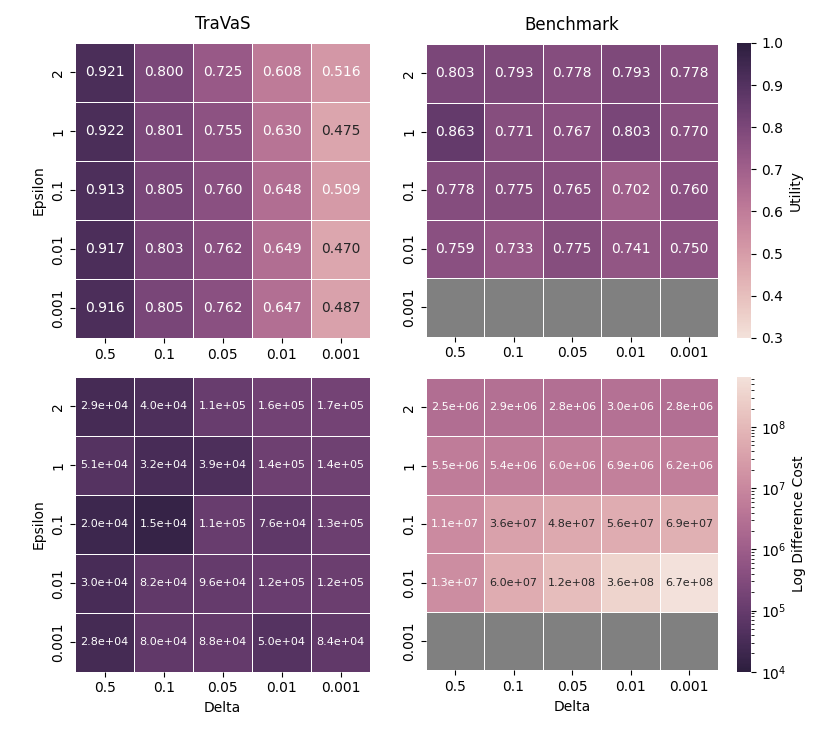

In [95]:
# load final data
util_single = np.loadtxt('single/util_single.txt')
util_multi = np.loadtxt('multi/util_multi.txt')
util_bench = np.loadtxt('benchmark/util_bench.txt')

cost_single = np.loadtxt('single/cost_single.txt')
cost_multi = np.loadtxt('multi/cost_multi.txt')
cost_bench = np.loadtxt('benchmark/cost_bench.txt')

util_best = np.maximum(util_single, util_multi)
util_bench = np.vstack([util_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
cost_best = np.minimum(cost_single, cost_multi)
cost_bench = np.vstack([cost_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_best, ax=ax[0,0], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(util_bench, ax=ax[0,1], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Utility'})
ax[1,0] = sns.heatmap(cost_best, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_bench, ax=ax[1,1], cmap=cmap_r, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Log Difference Cost'}, annot_kws={"fontsize":8})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()

<IPython.core.display.Javascript object>


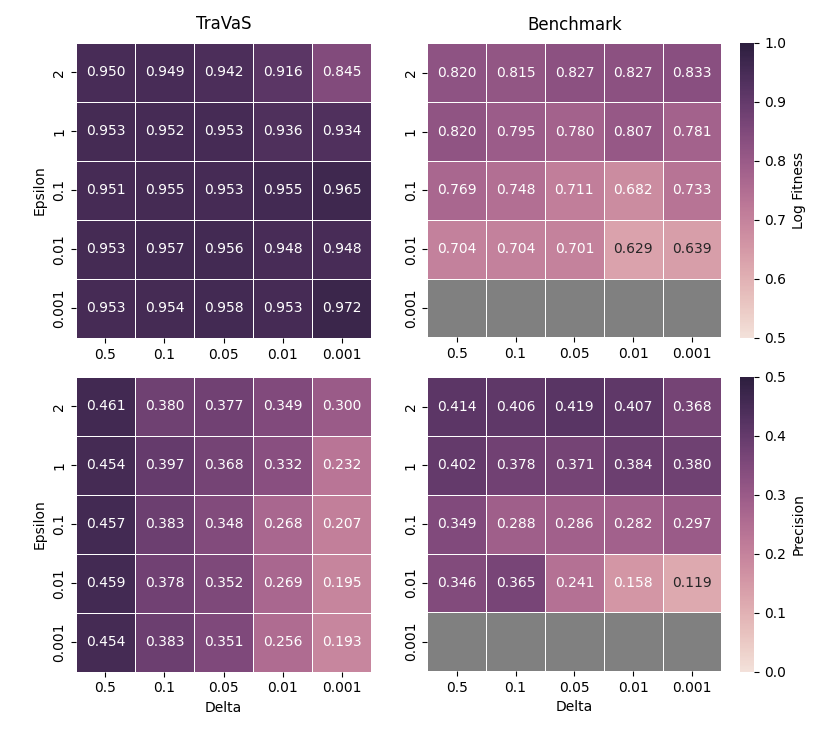

In [106]:
# load final data
prec_single = np.loadtxt('single/prec_single.txt')
prec_multi = np.loadtxt('multi/prec_multi.txt')
prec_bench = np.loadtxt('benchmark/prec_bench.txt')
prec_bench = np.vstack([prec_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
prec_best = np.maximum(prec_single, prec_multi)

fit_single = np.loadtxt('single/fit_single.txt')
fit_multi = np.loadtxt('multi/fit_multi.txt')
fit_bench = np.loadtxt('benchmark/fit_bench.txt')
fit_bench = np.vstack([fit_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
fit_best = np.maximum(fit_single, fit_multi)

gen_single = np.loadtxt('single/gen_single.txt')
gen_multi = np.loadtxt('multi/gen_multi.txt')
gen_bench = np.loadtxt('benchmark/gen_bench.txt')
gen_bench = np.vstack([gen_bench, [np.nan, np.nan, np.nan, np.nan, np.nan]])
gen_best = np.maximum(gen_single, gen_multi)

# create plots
f, ax = plt.subplots(2, 2, figsize=(8.3, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_best, ax=ax[0,0], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_bench, ax=ax[0,1], vmin=0.5, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Log Fitness'})
ax[1,0] = sns.heatmap(prec_best, ax=ax[1,0], cmap=cmap, square=True, vmin=0, vmax=0.5, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_bench, ax=ax[1,1], cmap=cmap, vmin=0, vmax=0.5, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01,0.001], xticklabels=[0.5,0.1,0.05,0.01,0.001], linewidths=.5, cbar_kws={'label': 'Precision'})
ax[0,0].set_title('TraVaS', pad=10)
ax[0,1].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
f.tight_layout()